# Purpose: Refining my differenced image preprocessing by generating synthetic streaks and extracting them

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import math
import cv2
import sep
from photutils import detect_threshold, detect_sources, deblend_sources, source_properties
from skimage.feature import canny
import skimage
from scipy import ndimage as ndi
import scipy
from scipy.optimize import minimize
import sys
from functools import partial
import scipy.stats as stats
import random
import reproject
from astropy.io import fits
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize

In [2]:
# generated from generate_streak_distribution.py
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
# for the values below use uniform dist instead
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]

# gain is the same for all images
gain = 6.2

# minimum amp of streak
min_amplitude = 1.5


def gaussian(x, offset, std, amp):
    return amp * np.exp(-np.power(x - offset, 2.) / (2 * np.power(std, 2.)))


def gaussian_streak(width, offset, std, amp, bkg):
    dist = gaussian(np.arange(width), offset, std, amp) + bkg
    return dist


def create_random_streak(amp_min):
    while True:
        std = stats.gamma.rvs(*params_gamma_width) * 0.05
        width = std * 10

        amplitude = stats.gamma.rvs(*params_gamma_amplitude)
        # amplitude = np.random.random() * 80 + amp_min

        if random.random() < 0.6:
            length = stats.gamma.rvs(*params_gamma_length)
        else:
            length = np.random.random() * 90 + 10

        streak = np.repeat(np.array([gaussian_streak(width, width / 2, std, amplitude, 0)]).T, length, axis=1)

        # use 2*std, which is "real" width
        if length / (std * 2) > 2 and amplitude > amp_min and length > 10 and width > 0:
            break

    return streak


def implant_random_streak(image):
    bkg = sep.Background(image)
    # print(bkg.globalrms)
    streak = create_random_streak(bkg.globalrms * min_amplitude)

    y_len, x_len = image.shape

    rotation = np.random.uniform(0, 360)
    streak = skimage.transform.rotate(streak, rotation, resize=True, order=3)

    # add shot noise
    streak = np.random.poisson(streak * gain)

    streak = streak/gain

    y_len_streak, x_len_streak = streak.shape
    x = np.random.randint(0, x_len - x_len_streak)
    y = np.random.randint(0, y_len - y_len_streak)

    new_image = np.copy(image)
    shape = streak.shape
    new_image[y:y + shape[0], x:x + shape[1]] += streak

    return new_image

In [51]:
def convert_sci_to_ref(file):
    filename = file.split("/")[-1]
    return "/media/rd1/ztf_neos/fits_files_resampled/" + filename[:-len("sciimg.resamp.fits")] + "refimg.resamp.fits"


def align(sci_fits, ref_fits):
    sci, sci_header = sci_fits
    ref, ref_header = ref_fits

    ref_aligned = reproject.reproject_interp((ref, ref_header), sci_header, return_footprint=False)

    return ref_aligned


def distance(c1, c2):
    return ((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2) ** 0.5


size = 80

filenames = glob.glob("/media/rd1/ztf_neos/fits_files_resampled/*_sciimg.resamp.fits")
filename_pairs = [[file, convert_sci_to_ref(file)] for file in filenames]

In [9]:
sci_file, ref_file = random.choice(filename_pairs)
sci_fits = fits.getdata(sci_file, header=True)
ref_fits = fits.getdata(ref_file, header=True)
ref = align(sci_fits, ref_fits)
sci = sci_fits[0]

In [12]:
y_len, x_len = sci.shape
images = []
for i in range(0, y_len, 50):
    for j in range(0, x_len, 50):
        if j + size >= x_len or i + size >= y_len:
            continue

        crop_sci = sci[i:i+80, j:j+80]
        crop_ref = ref[i:i+80, j:j+80]

        if np.sum(crop_sci == 0) >= 10 or np.sum(crop_ref == 0) >= 10 or np.sum(np.isnan(crop_sci)) > 0 or np.sum(np.isnan(crop_ref)) > 0:
            continue

        images.append([crop_sci, crop_ref])

In [30]:
def normalize(arr):
    vmin, vmax = ZScaleInterval().get_limits(arr)
    return np.clip((arr - vmin)/(vmax - vmin), 0, 1)

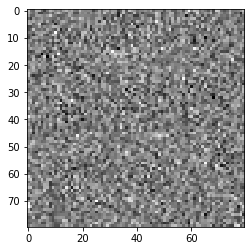

In [82]:
plt.imshow(normalize(images[200][0]), cmap="gray")

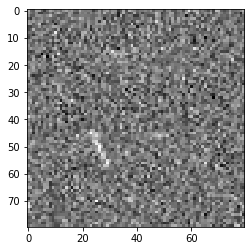

In [89]:
image = np.copy(images[200][0])
image = image.byteswap().newbyteorder()
image = implant_random_streak(image)
plt.imshow(normalize(image), cmap="gray")

True


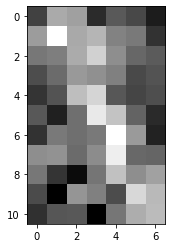

<Figure size 432x288 with 0 Axes>

In [91]:
# works = []
thresholds = [1.1, 1.3, 1.5, 1.7]
# for image, _ in real_images:
#     if image.size == 0:
#         works.append(False)
#         continue

# image = np.copy(np.array(image))

bkg = sep.Background(image)
image = image - bkg

did_work = False
for threshold in thresholds:

    threshold = bkg.rms() * threshold
#     threshold = detect_threshold(image, 1.5)
#     threshold = skimage.filters.thresholding.threshold_(image)

    segm = detect_sources(image, threshold, 20, connectivity=4)

    try:
        segm = deblend_sources(image, segm, 20, connectivity=4)
    except:
        break

    info = source_properties(image, segm)

    best_streak = None

    for obj in info:

        cutout = obj.data_cutout_ma
        elongation = obj.elongation
        bbox = [obj.bbox.ixmin, obj.bbox.ixmax, obj.bbox.iymin, obj.bbox.iymax]
        bbox = np.array(bbox, np.float64)

        length = distance(cutout.shape, (0,0))
        midpoint = (image.shape[0] / 2, image.shape[1] / 2)
        plt.imshow(normalize(image)[int(bbox[2]):int(bbox[3]), int(bbox[0]):int(bbox[1])], cmap="gray")
        plt.figure()
        if length > 8 and elongation > 2:
            did_work = True
            break

    if did_work:
        break
print(did_work)
# works.append(did_work)